In [1]:
import os
from glob import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
import cv2
import pandas as pd
import seaborn as sns
import plotly.express as px

In [154]:
df = pd.read_feather('../data/01/fer_2013.feather')

In [355]:
px.bar(
    df.target.value_counts(ascending=True), 
    barmode='group',
    text_auto=True, 
    title="Number of images by class",
    width=700
)

In [157]:
def rename(x):
    suffix = x.split('_')[-1]
    if x.startswith('Tr'):
        prefix = 'tr_'
    elif x.startswith('Pr'):
        prefix = 'pr_'
    else :
        prefix = 'pu_'
    return prefix + suffix
# df['filename'] = [rename(x) for x in [os.path.basename(f)[:-4] for f in df['file']]]
# df.to_feather('../data/01/fer_2013.feather')

In [10]:
def show_images(df, title_col=None, off=True, tight_layout=False, rows=8, suptitle=None):
    files = df.file
    if title_col:
        titles = df[title_col]
        iterator = zip(files, titles)
    else:
        iterator = files
    cols = len(files) // rows
    
    if len(files) % rows != 0:
        cols += 1
        
        
    plt.figure(figsize=(16, len(files) // rows + 4), tight_layout=tight_layout)
    plt.suptitle(suptitle)
    for i, f in enumerate(iterator):
        if isinstance(f, tuple):
            f, title = f
        img = mpimg.imread(f)
        ax = plt.subplot(cols, rows, i + 1)
        if title_col:
            plt.title(title)
        if off:
            ax.axis('off')
        plt.imshow(img, cmap=cm.gray)
    plt.show()

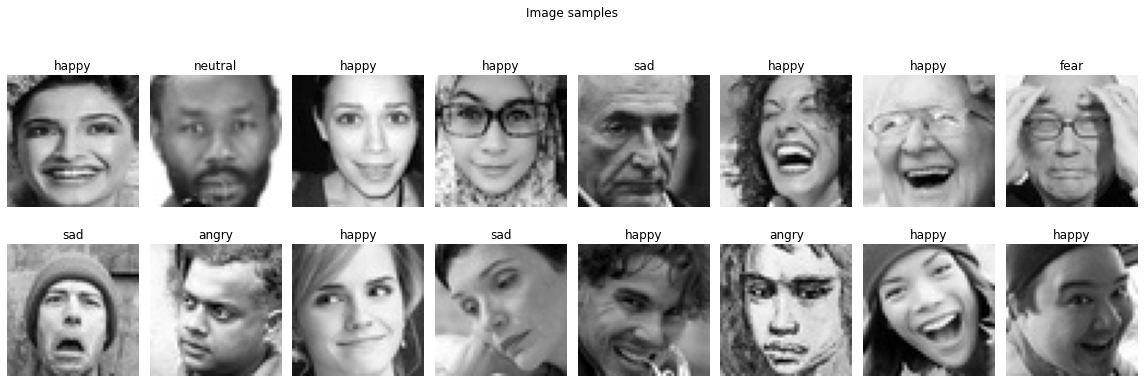

In [233]:
show_images(df.sample(16), title_col="target", tight_layout=True, suptitle="Image samples")

## Seek images mostly black or white

Taking the mean pixel value of the image (between 0 and 255), we will be able to detect these images.


In [330]:

def feature_extraction(df):
    means = []
    vars = []
    for img_path in tqdm(df.file.values):
        img = mpimg.imread(img_path)
        means.append(round(img.mean(), 2))
        vars.append(round(img.var(), 2))
    df["mean_px"] = means
    df["var_px"] = vars
    return df

df = feature_extraction(df)
df

100%|██████████| 35836/35836 [00:11<00:00, 3232.76it/s]


index                                               file     filename  \
0          0  ../data/01/fer_2013/fear/PrivateTest_94680058.jpg  pr_94680058   
1          1     ../data/01/fer_2013/fear/Training_65828754.jpg  tr_65828754   
2          2     ../data/01/fer_2013/fear/Training_28682417.jpg  tr_28682417   
3          3     ../data/01/fer_2013/fear/Training_63053875.jpg  tr_63053875   
4          4     ../data/01/fer_2013/fear/Training_88756840.jpg  tr_88756840   
...      ...                                                ...          ...   
35831  35882  ../data/01/fer_2013/surprise/Training_89567115...  tr_89567115   
35832  35883  ../data/01/fer_2013/surprise/Training_22645248...  tr_22645248   
35833  35884  ../data/01/fer_2013/surprise/Training_15408922...  tr_15408922   
35834  35885  ../data/01/fer_2013/surprise/Training_89421614...  tr_89421614   
35835  35886  ../data/01/fer_2013/surprise/PrivateTest_34696...  pr_34696648   

         target  has_attributes  mean_px   var_px  
0          fear               0   120.27  2581.33  
1          fear               1    48.56   373.78  
2          fear               1   145.15  6361.76  
3          fear               1   134.23  1681.83  
4          fear               1   123.89  1514.36  
...         ...             ...      ...      ...  
35831  surprise               1   185.46  2959.54  
35832  surprise               1   136.73  3955.30  
35833  surprise               1   152.75  3392.68  
35834  surprise               1   137.79  3778.91  
35835  surprise               1   132.37  2968.84  

[35836 rows x 7 columns]

In [331]:
import plotly.express as px

px.box(df["var_px"])

In [353]:
df.to_feather('../data/02/fer_2013_2.feather')

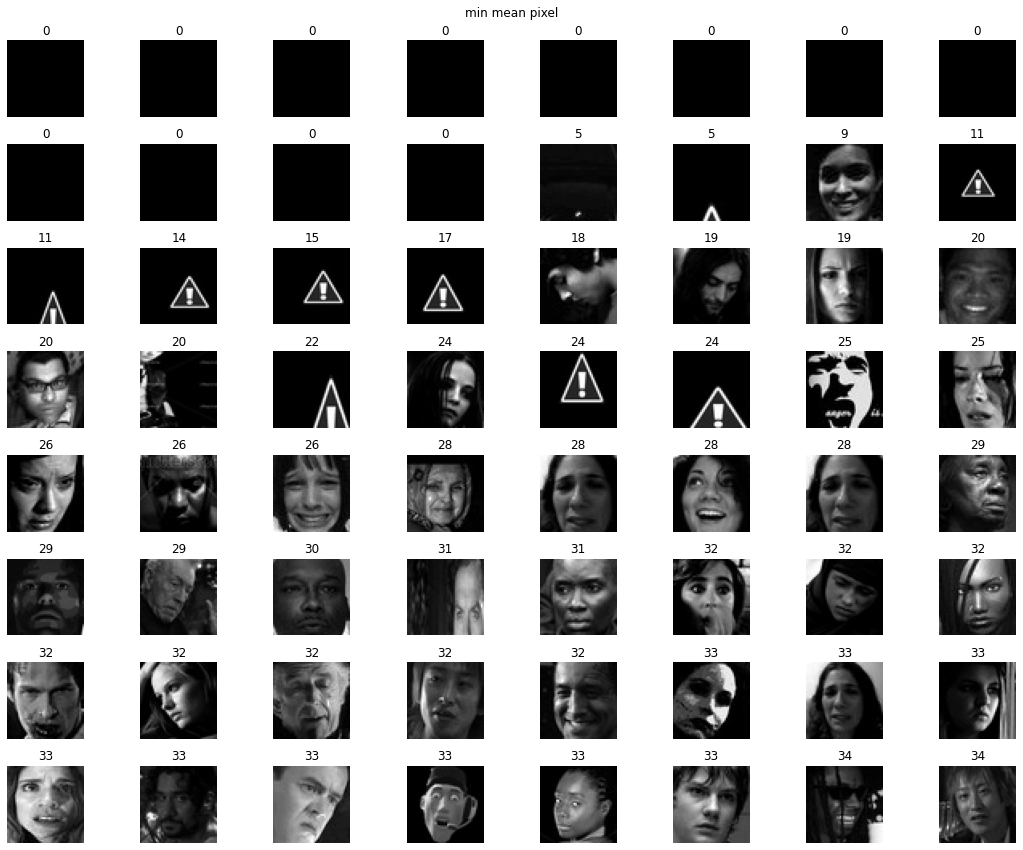

In [ ]:
min_mean = df.sort_values(by="mean_pixel")[:64]
show_images(min_mean, title_col="mean_pixel", suptitle="min mean pixel", tight_layout=True)

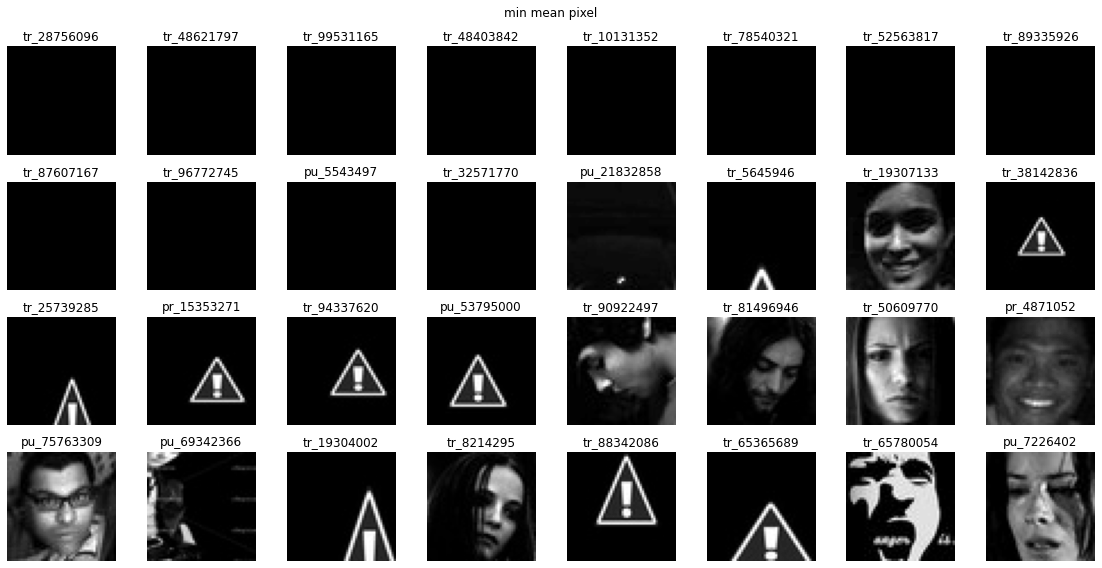

In [ ]:
min_outliers = df.sort_values(by="mean_pixel")[:32]
show_images(min_outliers, title_col="filename", suptitle="min mean pixel", tight_layout=True)

In [ ]:
not_out = [
    'tr_19307133',
    'tr_90922497',
    'tr_81496946',
    'tr_50609770',
    'pr_4871052',
    'pu_75763309',
    'tr_8214295',
    'tr_65780054',
    'pu_7226402'
]
to_remove = min_outliers[~min_outliers.filename.isin(not_out)]

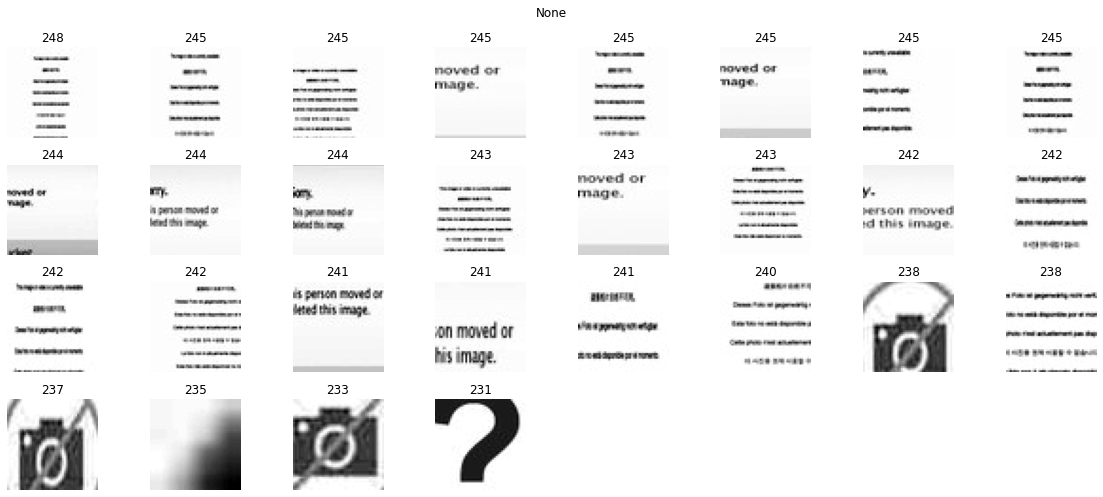

In [ ]:
max_mean = df.sort_values(by="mean_pixel")[:-29:-1]
show_images(max_mean, title_col="mean_pixel", tight_layout=True)

In [ ]:
to_remove = pd.concat((to_remove, max_mean))

In [ ]:
df = df.drop(labels=to_remove.index)
df.reset_index(inplace=True)
df.shape

(35836, 4)

In [ ]:
df.to_feather('../data/02/fer_2013_2.feather')

# Face attributes detection

Using HaarCascades, we try to detect face attributes (eye, nose, mouth...).
After some tests for tuning the classifier, parameters are set:
+ `scaleFactor` : 1.05
+ `minNeighbors` : 2

In [3]:
df = pd.read_feather('../data/02/fer_2013_2.feather')
df.head(1)

file     filename target  \
0  ../data/01/fer_2013/fear/PrivateTest_94680058.jpg  pr_94680058   fear   

   has_attributes  mean_px   var_px  
0               0   120.27  2581.33

Detecting face attributes with Haarcascades


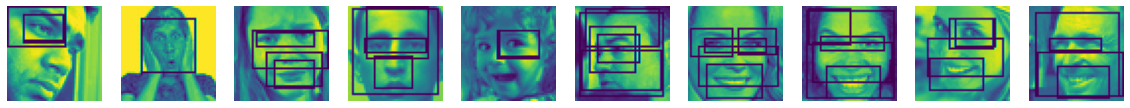

In [225]:
# HaarCascades classifiers
cascades = [os.path.join('../haarcascades/', haar) for haar in os.listdir('../haarcascades')]
rand_imgs = df.file.sample(10)

scale_factor = 1.05
min_neighbors = 2

print("Detecting face attributes with Haarcascades")
plt.figure(figsize=(20, 4), tight_layout=False)
for i, rand_img in enumerate(rand_imgs):
    ax = plt.subplot(1, len(rand_imgs), i + 1)
    ax.axis('off')
    img = mpimg.imread(rand_img)
    for cascade in cascades:
        face_cascade = cv2.CascadeClassifier(cascade)
        attrs = face_cascade.detectMultiScale(img, scaleFactor=scale_factor, minNeighbors=min_neighbors)
        if len(attrs) > 0:
            for i, attr in enumerate(attrs):
                x, y, w, h = attr
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
    plt.imshow(img)
plt.show()
            

For a first shallow cleaning of the data, we'll look at the images without any attribute detected.

In [4]:
def find_face_attributes(x):
    img = mpimg.imread(x)
    for cascade in cascades:
        scale_factor = 1.05
        min_neighbors = 2
        # try to catch more picture taken in profile
        if cascade == "haarcascade_profileface.xml":
            scale_factor=1.01
            min_neighbors = 1
        face_cascade = cv2.CascadeClassifier(cascade)
        attrs = face_cascade.detectMultiScale(img, scaleFactor=scale_factor, minNeighbors=min_neighbors)
        if len(attrs) > 0:
            return 1
    return 0

cascades = [os.path.join('../haarcascades/', haar) for haar in os.listdir('../haarcascades')]            

In [5]:
df["has_attributes"] = [find_face_attributes(x) for x in tqdm(df.file.values)]

100%|██████████| 35834/35834 [58:38<00:00, 10.18it/s]  


In [229]:
df.sample(5)

index                                               file     filename  \
5967    5974  ../data/01/fer_2013/neutral/Training_25902527.jpg  tr_25902527   
32116  32159  ../data/01/fer_2013/surprise/Training_47152690...  tr_47152690   
29350  29390  ../data/01/fer_2013/happy/PublicTest_69207826.jpg  pu_69207826   
731      731     ../data/01/fer_2013/fear/Training_14603239.jpg  tr_14603239   
6455    6463  ../data/01/fer_2013/neutral/Training_37127892.jpg  tr_37127892   

         target  mean_pixel  has_attributes  
5967    neutral          98               1  
32116  surprise         128               1  
29350     happy          72               1  
731        fear         157               1  
6455    neutral         160               0

In [6]:
df.to_feather('../data/03/fer_2013.feather')

## Images without attributes

In [7]:
df = pd.read_feather('../data/03/fer_2013.feather')

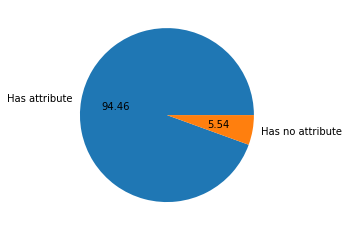

In [8]:
_ = plt.pie(
    df.has_attributes.value_counts(), 
    labels=["Has attribute", "Has no attribute"], 
    autopct="%.2f"
)

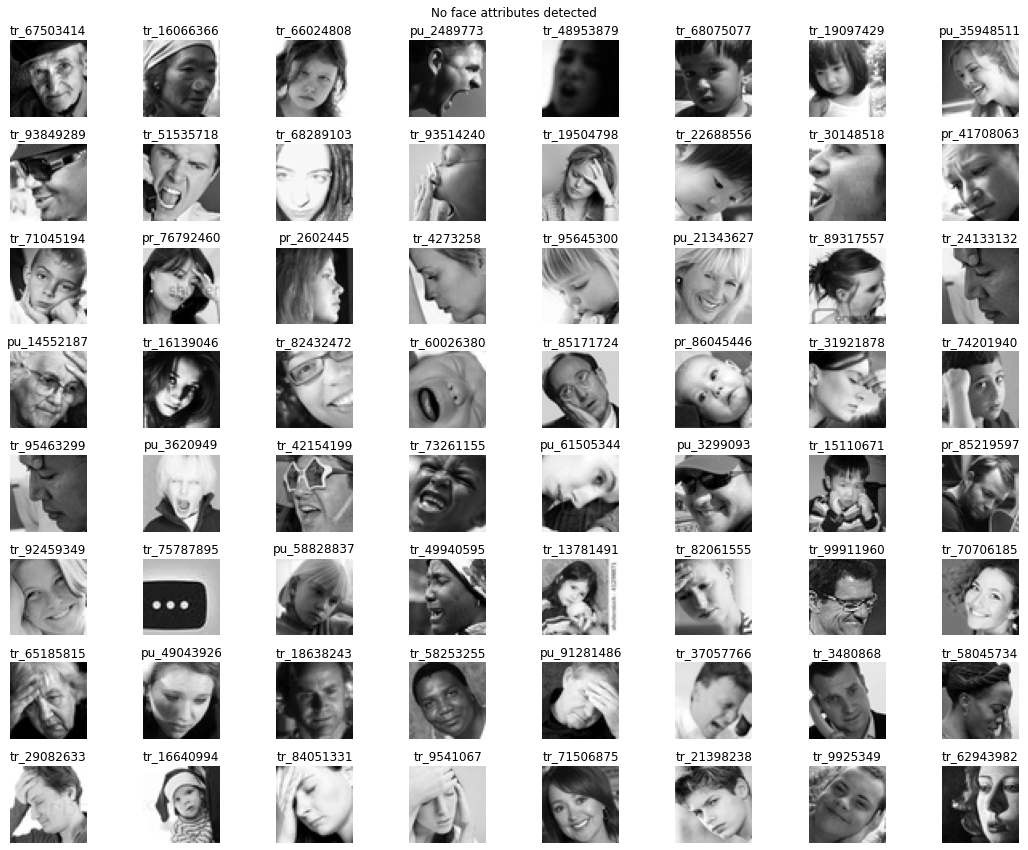

In [16]:
show_images(df[df["has_attributes"] == 0].sample(64), title_col="filename", tight_layout=True, suptitle="No face attributes detected")

Results are not what I expected.
Most of the images seem to provide enough information to be valid.